# 1. Prepare Dataset suitable for RFM model

In [ ]:
# 1.1. Import data - Excel file
# Install dataprep to create report for each column
!pip install dataprep
from dataprep.eda import create_report

In [ ]:
# Import Numpy to perform calculation functions
import numpy as np

# Import Pandas to read excel file data into DataFrame for multidimensional data structure, easy to handle data type for each column. DataFrame provides an efficient way to slice data; flexible way to merge, join or reshape data.
import pandas as pd

# Import os to be able to use functions/methods to manipulate both Files and Folders. -> need to open Folder in ggDrive
import os

# Import matplotlib.pyplot provides charts for data visualization
import matplotlib.pyplot as plt

# Seaborn is an extension of matplotlib, but is commonly used with data types from DataFrame.
import seaborn as sns

# Import warnings is used to display warning messages.
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Access the files stored in my Drive account from within Colab
# To mount my Drive account
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path = '/content/drive/MyDrive/'

df = pd.read_excel(path+"ecommerce_retail.xlsx")

In [ ]:
# Get sheet first do sheet_name=0 is called df
print(df)

       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID         Country  
0      

In [ ]:
# Get the second sheet so sheetname=1 is called Segmentation
Segmentation = pd.read_excel(path+"ecommerce_retail.xlsx", sheet_name=1)
print(Segmentation)

In [ ]:
# Dataset has 2 DataFrame which are df and Segmentation
# 1.2. Check and handle df
# Missing data, Duplicates, Incorrect data types
   # check info
print(df.info())

In [ ]:
   # check describe
print(df.describe())

In [ ]:
   # Identifies how many isna rows in each column
print(df.isna().sum())

In [ ]:
   # Identifies how many duplicated rows in a DataFrame
print(df.duplicated().sum())

In [ ]:
# Handle df dataframe
# Filter delivered transactions not cancelled. Because I need to analyze Customers who bought the product.
# InvoiceNo starts with a 'C' which indicates a cancel order so I need to delete these rows. Call df_not_cancel
df = df[~df['InvoiceNo'].astype(str).str.contains('C')]

print(df)

In [ ]:
# df.describe() has Quantity <0
# Filter quantity > 0 by df_not_cancel -> get rows have quantity > 0
df = df[df['Quantity'] >0]
print(df)

In [ ]:
# df.describe() has UnitPrice <0
# Filter UnitPrice > 0 by df_quantity -> get rows have UnitPrice > 0
df = df[df['UnitPrice'] >0]
print(df)

In [ ]:
   # Identifies how many isna rows in each column
print(df.isna().sum())

In [ ]:
# drop null values of column 'CustomerID' in dataframe
df.dropna(subset=['CustomerID'], how='all')
df['CustomerID'] = df['CustomerID'].dropna()
df = df.dropna(axis=1,how='all')
df.dropna(subset=['CustomerID'], inplace=True)

print(df.isna().sum())

In [ ]:
# create report to visually see the value of each column
create_report(df)

In [ ]:
# I see that in the country column, United Kingdom accounts for 91.51%, so I want to focus on analyzing only customers in the United Kingdom.
# Filter only United Kingdom
ecommerce_retail_onlyUK = df[df['Country'] == "United Kingdom"]
print(ecommerce_retail_onlyUK)

In [ ]:
# 1.3. Check and handle Segmentation. This is Dim table
# I want to merge on RFM_score, so I will transform Segmentation table
   # Convert comma-seperated string to a list of RFM scores
Segmentation['RFM Score'] = Segmentation['RFM Score'].str.split(',')

   #  Transform each element of a list of RFM scores to a row
Segmentation = Segmentation.explode('RFM Score').reset_index(drop=True)

   # Rename RFM Score column to RFM_Score
Segmentation.rename(columns={"RFM Score":"RFM_Score"}, inplace= True)

print(Segmentation)

            Segment RFM_Score
0         Champions       555
1         Champions       554
2         Champions       544
3         Champions       545
4         Champions       454
..              ...       ...
120  Lost customers       112
121  Lost customers       121
122  Lost customers       131
123  Lost customers       141
124  Lost customers       151

[125 rows x 2 columns]


In [ ]:
   # check info
print(Segmentation.info())

In [ ]:
# Change RFM_Score's Dtype from object to int
Segmentation['RFM_Score'] = Segmentation['RFM_Score'].astype(int)
print(Segmentation.info())

# 2.	Determine how to calculate and calculate the R, F, M scores of each customer. The calculation date of the R index is 2011-12-31

In [ ]:
# calculate Recency
# change InvoiceDate to_datetime
ecommerce_retail_onlyUK['InvoiceDate'] = pd.to_datetime(ecommerce_retail_onlyUK['InvoiceDate'])

# change 2011-12-31 to_datetime
present_date = pd.to_datetime('2011-12-31')

# calculate Recency = (2011-12-31 – InvoiceDate)
ecommerce_retail_onlyUK['Recency'] = (present_date - ecommerce_retail_onlyUK['InvoiceDate']).dt.days

print(ecommerce_retail_onlyUK)

In [ ]:
# calculate Monetary = Quantity* UnitPrice
ecommerce_retail_onlyUK['Monetary'] = ecommerce_retail_onlyUK['Quantity'] * ecommerce_retail_onlyUK['UnitPrice']
print(ecommerce_retail_onlyUK)

In [ ]:
# create table Re_Fre_Mone with 4 columns: CustomerID, Recency, Frequency, Monetary
RFM_score = ecommerce_retail_onlyUK.groupby('CustomerID').agg({
                                                              'Recency': 'min',
                                                              'InvoiceNo': 'count',
                                                              'Monetary': 'sum'
                                                               }).reset_index()

print(RFM_score)

In [ ]:
# Rename InvoiceNo column to Frequency
RFM_score.rename(columns={"InvoiceNo":"Frequency"}, inplace= True)

print(RFM_score)

      CustomerID  Recency  Frequency  Monetary
0        12346.0      346          1  77183.60
1        12747.0       23        103   4196.01
2        12748.0       21       4595  33719.73
3        12749.0       24        199   4090.88
4        12820.0       24         59    942.34
...          ...      ...        ...       ...
3915     18280.0      298         10    180.60
3916     18281.0      201          7     80.82
3917     18282.0       28         12    178.05
3918     18283.0       24        756   2094.88
3919     18287.0       63         70   1837.28

[3920 rows x 4 columns]


# 3. Give a calculation method with corresponding scores on a scale of 1 to 5. Use the quintile method of Statistics

In [ ]:
# 3.1 Calculate column Recency score
RFM_score['R_score'] = pd.qcut(RFM_score['Recency'], 5)
RFM_score['R_score'] = pd.qcut(RFM_score['Recency'], q=[0, 0.2, 0.4, 0.6, 0.8, 1], precision = 0)
RFM_score['R_score'] = pd.qcut(RFM_score['Recency'], q=[0, 0.2, 0.4, 0.6, 0.8, 1], labels=["5", "4", "3", "2", "1"])

print (RFM_score)

In [ ]:
# 3.1 Calculate column Frequency score
RFM_score['F_score'] = pd.qcut(RFM_score['Frequency'], 5)
RFM_score['F_score'] = pd.qcut(RFM_score['Frequency'], q=[0, 0.2, 0.4, 0.6, 0.8, 1], precision = 0)
RFM_score['F_score'] = pd.qcut(RFM_score['Frequency'], q=[0, 0.2, 0.4, 0.6, 0.8, 1], labels=["1", "2", "3", "4", "5"])
print (RFM_score)

In [ ]:
# 3.1 Calculate column Monetary score
RFM_score['M_score'] = pd.qcut(RFM_score['Monetary'], 5)
RFM_score['M_score'] = pd.qcut(RFM_score['Monetary'], q=[0, 0.2, 0.4, 0.6, 0.8, 1], precision = 0)
RFM_score['M_score'] = pd.qcut(RFM_score['Monetary'], q=[0, 0.2, 0.4, 0.6, 0.8, 1], labels=["1", "2", "3", "4", "5"])
print (RFM_score)

      CustomerID  Recency  Frequency  Monetary R_score F_score M_score
0        12346.0      346          1  77183.60       1       1       5
1        12747.0       23        103   4196.01       5       4       5
2        12748.0       21       4595  33719.73       5       5       5
3        12749.0       24        199   4090.88       5       5       5
4        12820.0       24         59    942.34       5       4       4
...          ...      ...        ...       ...     ...     ...     ...
3915     18280.0      298         10    180.60       1       1       1
3916     18281.0      201          7     80.82       1       1       1
3917     18282.0       28         12    178.05       5       1       1
3918     18283.0       24        756   2094.88       5       5       5
3919     18287.0       63         70   1837.28       3       4       4

[3920 rows x 7 columns]


# 4. Use Segmentation table to group each customer

In [ ]:
# Combine R_score, F_score, M_score columns to RFM_score column
def RFM_Score(RFM_score):
    return str(RFM_score['R_score']) + str(RFM_score['F_score']) + str(RFM_score['M_score'])
RFM_score['RFM_Score'] = RFM_score.apply(RFM_Score,axis=1)

print(RFM_score)

In [ ]:
print(RFM_score.info())

In [ ]:
# Change Dtype of R_score,F_score,M_score,RFM_Score from object to int
RFM_score['R_score'] = RFM_score['R_score'].astype(int)
RFM_score['F_score'] = RFM_score['F_score'].astype(int)
RFM_score['M_score'] = RFM_score['M_score'].astype(int)
RFM_score['RFM_Score'] = RFM_score['RFM_Score'].astype(int)
print(RFM_score.info())

In [ ]:
# Left join RFM_score and Segmentation to RMF_model
RFM_model = RFM_score.merge(Segmentation, on='RFM_Score', how='left')

# Sort CustomerID
RFM_model = RFM_model.sort_values(by='CustomerID')

print(RFM_model)

      CustomerID  Recency  Frequency  Monetary  R_score  F_score  M_score  \
0        12346.0      346          1  77183.60        1        1        5   
1        12747.0       23        103   4196.01        5        4        5   
2        12748.0       21       4595  33719.73        5        5        5   
3        12749.0       24        199   4090.88        5        5        5   
4        12820.0       24         59    942.34        5        4        4   
...          ...      ...        ...       ...      ...      ...      ...   
3915     18280.0      298         10    180.60        1        1        1   
3916     18281.0      201          7     80.82        1        1        1   
3917     18282.0       28         12    178.05        5        1        1   
3918     18283.0       24        756   2094.88        5        5        5   
3919     18287.0       63         70   1837.28        3        4        4   

      RFM_Score           Segment  
0           115  Cannot Lose Them  
1  

# 5. Visualize the number of Segment sets

In [ ]:
# 5.1 Histogram (sns.distplot)
# Find max Recency of each R_score
print(RFM_model['Recency'].min())
print(RFM_model.groupby('R_score').agg({
                                                'Recency': 'max'
                                                  }).reset_index())

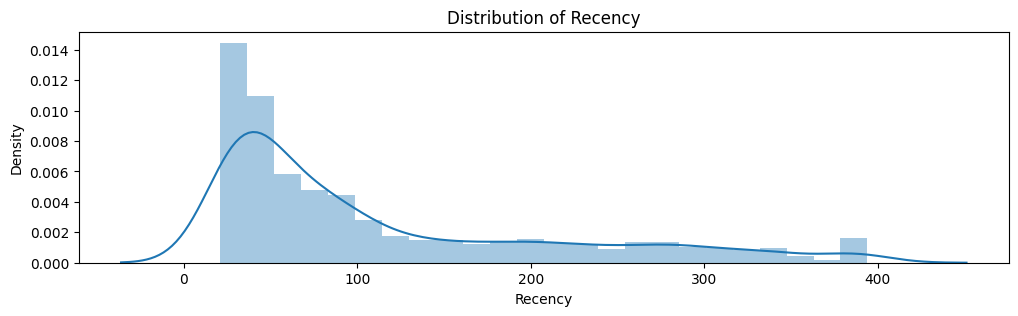

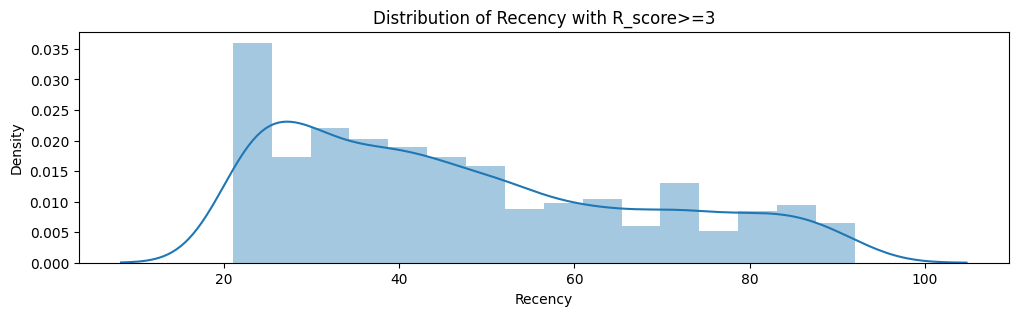

In [ ]:
# show distribution of Recency of the model
fix, ax = plt.subplots(figsize=(12,3))
sns.distplot(RFM_model['Recency'])
ax.set_title('Distribution of Recency')
plt.show()

# show distribution of Recency with R_score>=3
fix, ax = plt.subplots(figsize=(12,3))
RFM_model['Recency'] = pd.to_numeric(RFM_model['Recency'], errors='coerce')
sns.distplot(RFM_model[RFM_model['Recency']<=92]['Recency'])
ax.set_title('Distribution of Recency with R_score>=3')
plt.show()


In [ ]:
# Find max Frequency of each F_score
print(RFM_model['Frequency'].min())
print(RFM_model.groupby('F_score').agg({
                                                'Frequency': 'max'
                                                  }).reset_index())

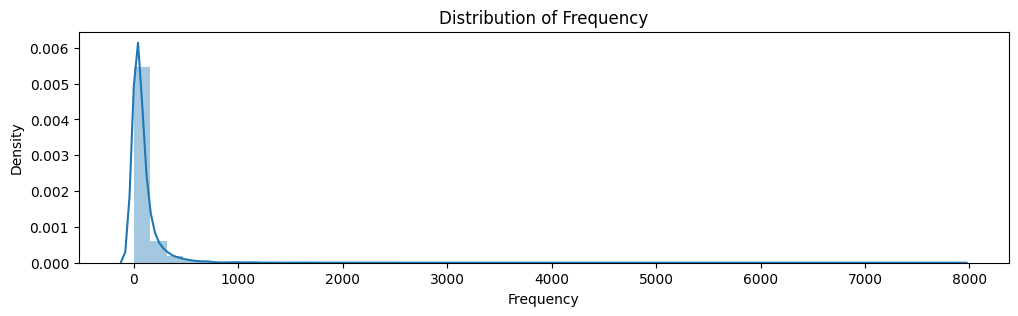

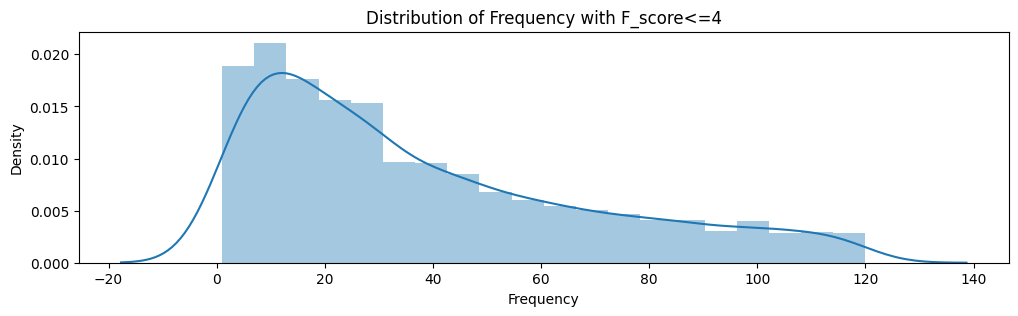

In [ ]:
# show distribution of Frequency of the model
fix, ax = plt.subplots(figsize=(12,3))
sns.distplot(RFM_model['Frequency'])
ax.set_title('Distribution of Frequency')
plt.show()

# show distribution of Recency with F_score<=4
fix, ax = plt.subplots(figsize=(12,3))
RFM_model['Frequency'] = pd.to_numeric(RFM_model['Frequency'], errors='coerce')
sns.distplot(RFM_model[RFM_model['Frequency']<=120]['Frequency'])
ax.set_title('Distribution of Frequency with F_score<=4')
plt.show()

In [ ]:
# Find max Monetary of each M_score
print(RFM_model['Monetary'].min())

print(RFM_model.groupby('M_score').agg({
                                  'Monetary': 'max'
                                  }).reset_index())

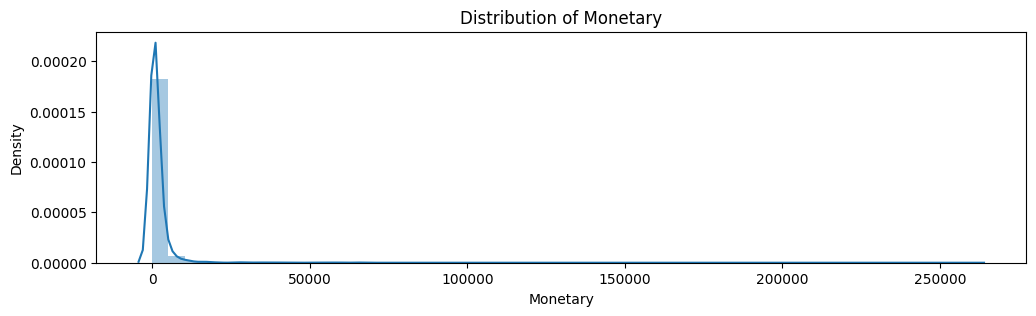

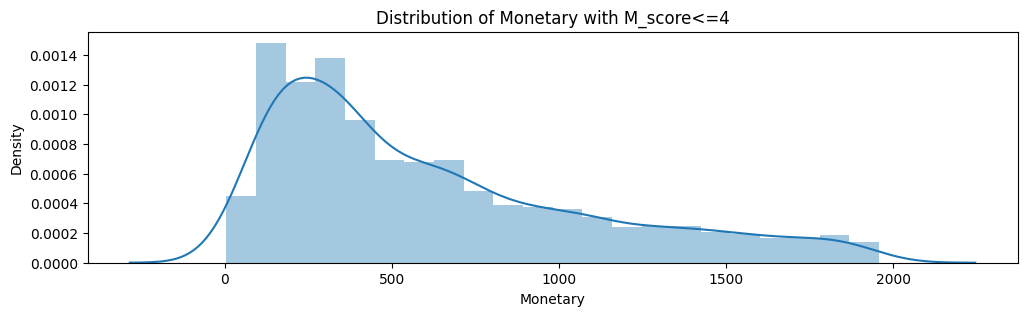

In [ ]:
# show distribution of Monetary of the model
fix, ax = plt.subplots(figsize=(12,3))
sns.distplot(RFM_model['Monetary'])
ax.set_title('Distribution of Monetary')
plt.show()

# show distribution of Monetary with M_score<=4
fix, ax = plt.subplots(figsize=(12,3))
RFM_model['Monetary'] = pd.to_numeric(RFM_model['Monetary'], errors='coerce')
sns.distplot(RFM_model[RFM_model['Monetary']<=1957.32]['Monetary'])
ax.set_title('Distribution of Monetary with M_score<=4')
plt.show()

In [ ]:
# 5.2 Treemap (squarify.plot)
# create grp_Segment table
grp_Segment = RFM_model.groupby('Segment').agg({
                                        'CustomerID': 'count',
                                        'Monetary' : 'sum'
                                        }).reset_index()
   # Rename RFM Score column to RFM_Score
grp_Segment.rename(columns={"CustomerID":"Cust_count"}, inplace= True)
grp_Segment.rename(columns={"Monetary":"Sales"}, inplace= True)
print(grp_Segment)

In [ ]:
# Total number of company customers
print(grp_Segment['Cust_count'].sum())

# Total number of company customers
print(grp_Segment['Sales'].sum())

In [ ]:
# percentage of sales in total call Cust_Percent
grp_Segment['Cust_Percent'] = grp_Segment['Cust_count'] / total_Cust

# percentage of sales in total call Sale_Percent
grp_Segment['Sale_Percent'] = grp_Segment['Sales'] / total_Sale

print(grp_Segment)

In [ ]:
# create colors
colors = ['#FF0000', '#00FFFF', '#FFFF00', '#A52A2A', '#800080', '#00FF00', '#808000', '#FFC0CB', '#FFA500', '#FF00FF', '#735F6E']

# Install squarify
!pip install squarify
import squarify

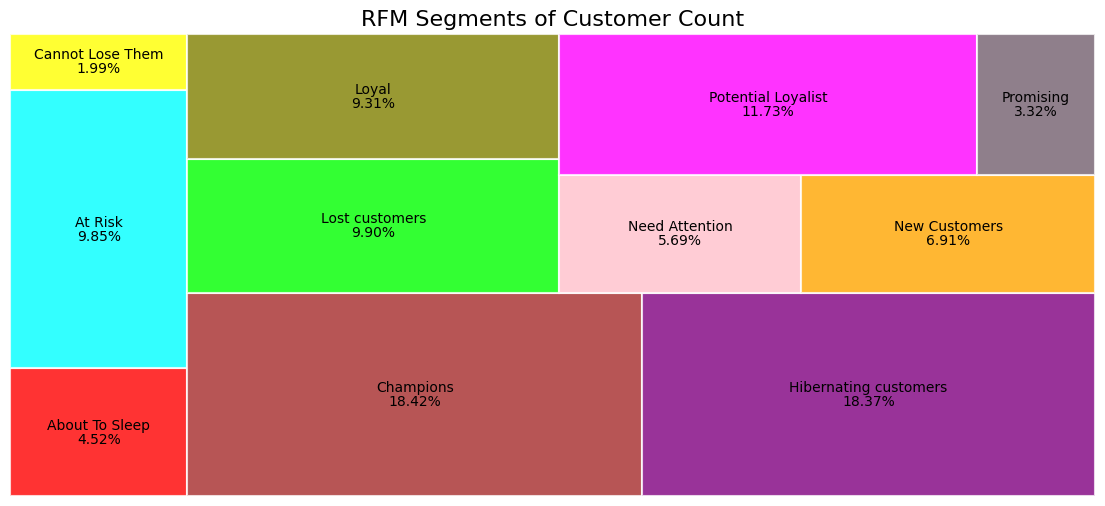

In [ ]:
# Segment by Customers treemap
fix, ax = plt.subplots(1, figsize=(14,6))

squarify.plot(sizes = grp['Cust_count'],
              label = grp['Segment'],
              value = [f'{x*100:.2f}%' for x in grp_Segment['Cust_Percent']],
              alpha = 0.8,
              color = colors,
              bar_kwargs = dict(linewidth=1.5, edgecolor="white")
              )

plt.title('RFM Segments of Customer Count', fontsize=16)
plt.axis('off')
plt.show()

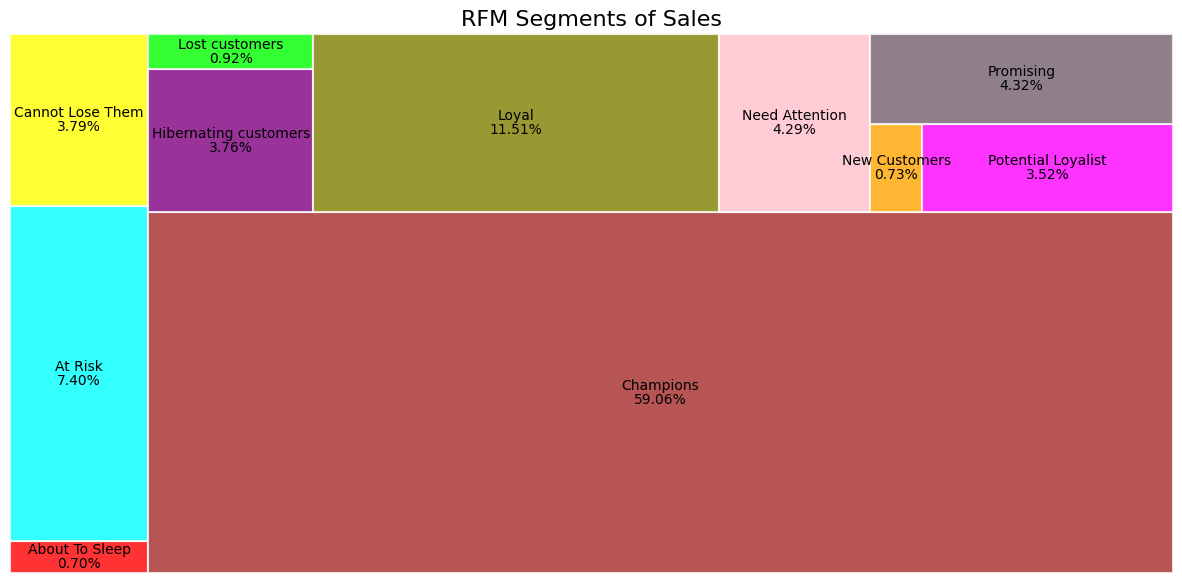

In [ ]:
# Segment by total sales treemap
fix, ax = plt.subplots(1, figsize=(15,7))

squarify.plot(sizes = grp['Sales'],
              label = grp['Segment'],
              value = [f'{x*100:.2f}%' for x in grp_Segment['Sale_Percent']],
              alpha = 0.8,
              color = colors,
              bar_kwargs = dict(linewidth=1.5, edgecolor="white")
              )

plt.title('RFM Segments of Sales', fontsize=16)
plt.axis('off')
plt.show()